**bag of words**: matriz contendo uma variação de 0 a 1 para representar a importância de uma palavra em uma sentença.

### bag of words com count vectorizer

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer()

import pandas as pd
import numpy as np
import itertools
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import gensim

In [4]:
clean_questions = pd.read_csv('clean_data.csv')

In [5]:
# separando o texto da variável alvo
list_corpus = clean_questions['text'].tolist()
list_labels = clean_questions['class_label'].tolist()

# separando entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=40)

# aprendendo o vocabulario e contabilizando os termos para teste
X_train_counts = count_vectorizer.fit_transform(X_train)

# contabilizando os termos no vocabulário aprendido para treino
X_test_counts = count_vectorizer.transform(X_test)

## Visualizando o vocabulário

**Tentativa de identificar alguma estrutura ou agrupamento.**

Dimensionality reduction using **truncated SVD** (aka LSA).

This transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with sparse matrices efficiently.

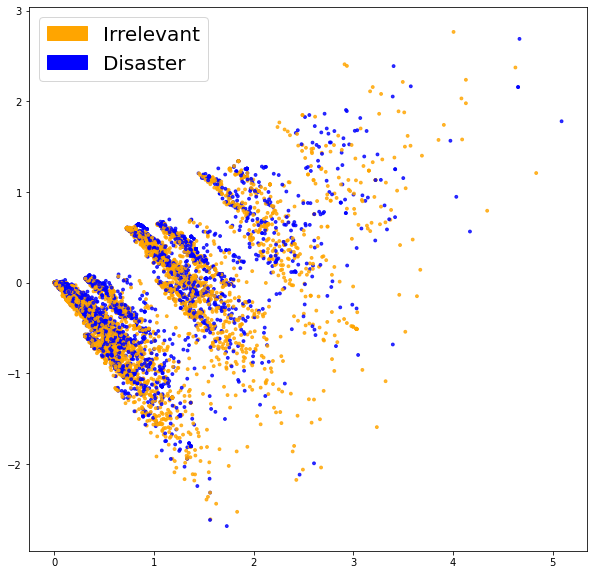

In [6]:
# funcao do plot do grafico com distribuicao de vocabulario por variavel alvo
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Irrelevant')
            green_patch = mpatches.Patch(color='blue', label='Disaster')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 20})
            
fig = plt.figure(figsize=(10, 10))          
plot_LSA(X_train_counts, y_train)
plt.show()

Os dados estão muito juntos. Não há agrupamento bem definido. 

## Treinando o Classificador

**Regressão Logística**: modelo estatístico usado para determinar a probabilidade de um evento acontecer. Ele mostra a relação entre os recursos e, em seguida, calcula a probabilidade de um determinado resultado. A regressão logística é usada no aprendizado de máquina (ML) para ajudar a criar previsões precisas. 
    
    **Multinomial**: várias classes

*Curva em S*

In [7]:
clf = LogisticRegression(C=30, class_weight='balanced', solver='newton-cg',
                        multi_class='multinomial', n_jobs=1, random_state=40)

# treinando o modelo com o vocabulário contruído e as variáveis alvo
clf.fit(X_train_counts, y_train)

# realizando as predições para o conjunto de teste
y_predicted_counts = clf.predict(X_test_counts)

## Avaliando o Classificador

Métricas utilizadas: precisão, cobertura e medida-f

In [8]:
# extracao das metricas usando os dados de teste
def get_metrics(y_test, y_predicted):
    # true positives / (true positives + false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                               average='weighted')
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                         average='weighted')
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # (true positives + true negatives) / total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" %
     (accuracy, precision, recall, f1))

accuracy = 0.754, precision = 0.752, recall = 0.754, f1 = 0.753


matriz de confusão

In [9]:
# funcao para plotar a matriz de confusao
def plot_confusion_matrix(cm, classes, normalize=False,
                         title='Matriz de Confusao',
                         cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max()/2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i,j], fmt), horizontalalignment='center',
                color='white' if cm[i,j] < thresh else 'black', fontsize=40)
        
    plt.tight_layout()
    plt.ylabel('True Label', fontsize=30)
    plt.xlabel('Predicted Label', fontsize=30)
        
    return plt

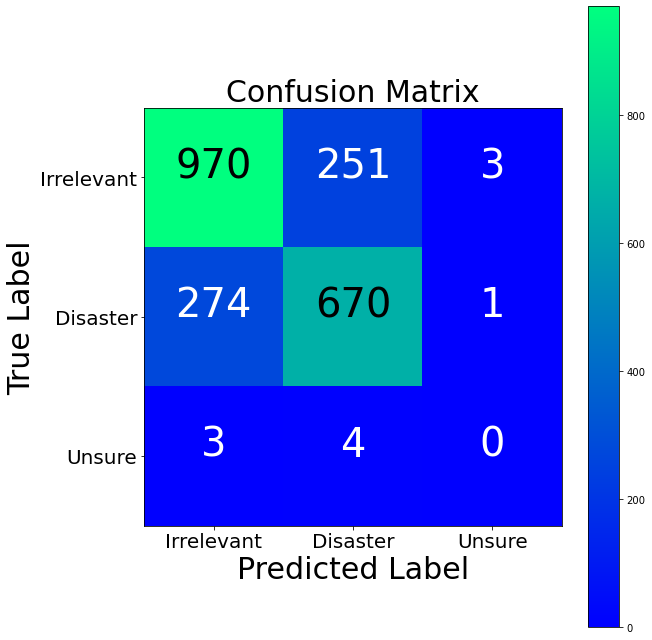

Count Vectorizer Confusion Matrix
[[970 251   3]
 [274 670   1]
 [  3   4   0]]


In [10]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(9,9))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster','Unsure'],
                            normalize=False, title='Confusion Matrix')
plt.show()
print('Count Vectorizer Confusion Matrix')
print(cm)

**sorted()**: Return a new list containing all items from the iterable in ascending order.

**zip()**: A zip object yielding tuples until an input is exhausted.

In [11]:
# identificar as palavras mais importantes na tomada de decisao
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    # loop for each class
    classes = {}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key=lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {'tops':tops, 'bottom':bottom}
    return classes
importance = get_most_important_features(count_vectorizer, clf, 10)

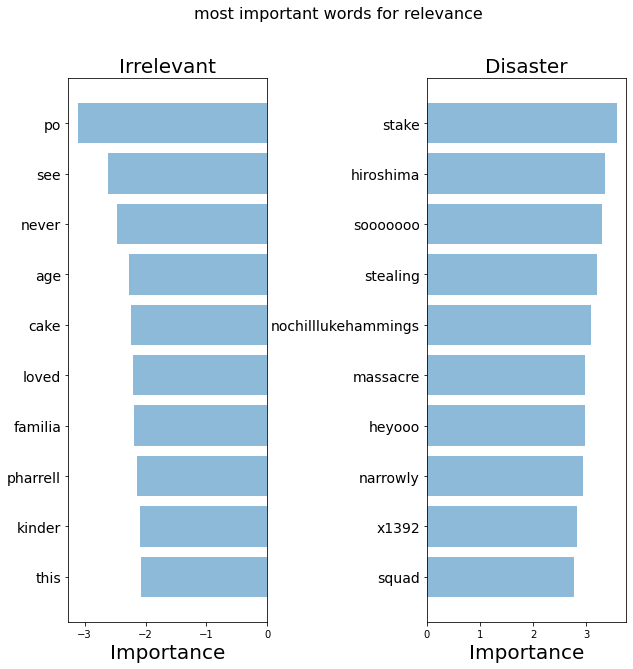

In [12]:
# plotando as features mais importantes
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    fig = plt.figure(figsize=(10,10))
    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)    
    plt.title('Irrelevant', fontsize=20)    
    plt.yticks(y_pos, bottom_words, fontsize=14)    
    plt.suptitle('Key words', fontsize=16)    
    plt.xlabel('Importance', fontsize=20)        
    plt.subplot(122)    
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)    
    plt.title('Disaster', fontsize=20)    
    plt.yticks(y_pos, top_words, fontsize=14)    
    plt.suptitle(name, fontsize=16)    
    plt.xlabel('Importance', fontsize=20)        
    plt.subplots_adjust(wspace=0.8)    
    plt.show() 
top_scores = [a[0] for a in importance[1]['tops']]
top_words = [a[1] for a in importance[1]['tops']]
bottom_scores = [a[0] for a in importance[1]['bottom']]
bottom_words = [a[1] for a in importance[1]['bottom']]
plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "most important words for relevance")

O classificador está conseguindo encontrar termos realmente relevantes para desastres, porém ainda há ruídos.

## Capturando o significado semântico das palavras

### word2vec

**word2vec**: modelo pré-treinado que mapeia palavras semanticamente relacionadas.

trabalhando com média das pontuações de similaridade: qanto mais próximas semanticamente, mais próximo será o peso das palavras.

In [17]:
# treinando a matriz de relacao com as noticias do google
word2vec_path = "GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format("https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit", binary=True)

ValueError: invalid literal for int() with base 10: '<!DOCTYPE'

In [18]:
# calculando a distância sem^ntica entre as palavras
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

# montagem do arquivo de treinamento contendo a relacao semantica entre as palavras
def get_word2vec_embeggins(vectors, clean_questions, generate_missing=False):
    embeggins = clean_questions['tokens'.apply(lambda x: get_average_word2vec(x, vectors, generate_missing=generate_missing))]
    return embeggins

In [20]:
embeggins = get_word2vec_embeggins(word2vec, clean_questions)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeggins, list_labels, test_size=.2, random_state=40)
fig = plt.figure(figsize=(10,10))
plot_LSA(embeggins, list_labels)
plt.show()

NameError: name 'word2vec' is not defined

In [21]:
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', multi_class='multinomial', random_state=40)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

NameError: name 'X_train_word2vec' is not defined

In [22]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec,recall_word2vec, f1_word2vec))


NameError: name 'y_test_word2vec' is not defined

In [23]:
cm_w2v = confusion_matrix(y_test_word2vec, y_predicted_word2vec)
fig = plt.figure(figsize=(10,10))
plot = plot_confusion_matrix(cm_w2v, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion Matrix')
plt.show()
print("Word2Vec Confusion Matrix")
print(cm_w2v)
print("TFIDF Confusion Matrix")
print(cm2)
print("BoW Confusion Matrix")
print(cm)

NameError: name 'y_test_word2vec' is not defined